Please note this code has been taken from: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import torch

import xgboost as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [ ]:
PATH_TRAIN_CSV = '/content/drive/MyDrive/ml_competition1_data/train.csv'
df_train = pd.read_csv(PATH_TRAIN_CSV)
df_train.head()

,SNo,lat,lon,TMQ,U850,V850,UBOT,VBOT,QREFHT,PS,...,T200,T500,PRECT,TS,TREFHT,Z1000,Z200,ZBOT,time,Label
0,1,21.707953,275.0000,78.909431,-58.805229,36.200672,-58.260475,-0.722955,0.022321,97497.79688,...,227.119232,273.045563,0.000014,302.350861,300.026764,66.339836,12400.22754,66.241585,20031024,1
1,2,21.707953,275.0000,78.909431,-58.805229,36.200672,-58.260475,-0.722955,0.022321,97497.79688,...,227.119232,273.045563,0.000014,302.350861,300.026764,66.339836,12400.22754,66.241585,20031024,1
2,3,21.473272,275.0000,80.641357,-42.340290,58.060246,-56.400234,26.484743,0.022204,96611.60156,...,229.172897,273.580810,0.000014,302.350861,299.798828,66.165573,12371.33203,66.165268,20031024,1
3,4,21.473272,275.0000,80.641357,-42.340290,58.060246,-56.400234,26.484743,0.022204,96611.60156,...,229.172897,273.580810,0.000014,302.350861,299.798828,66.165573,12371.33203,66.165268,20031024,1
4,5,21.707953,275.3125,76.891205,-45.996342,42.691631,-48.993065,10.246445,0.022328,98168.55469,...,224.642563,272.152283,0.000010,302.462708,300.160187,66.880089,12386.88574,66.275246,20031024,1


In [ ]:
df_train_reduced = df_train[['lat', 'lon', 'TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT',
       'PS', 'PSL', 'T200', 'T500', 'PRECT', 'TS', 'TREFHT', 'Z1000', 'Z200',
       'ZBOT', 'time', 'Label']]
df_train_reduced.head()

,lat,lon,TMQ,U850,V850,UBOT,VBOT,QREFHT,PS,PSL,T200,T500,PRECT,TS,TREFHT,Z1000,Z200,ZBOT,time,Label
0,21.707953,275.0000,78.909431,-58.805229,36.200672,-58.260475,-0.722955,0.022321,97497.79688,97498.90625,227.119232,273.045563,0.000014,302.350861,300.026764,66.339836,12400.22754,66.241585,20031024,1
1,21.707953,275.0000,78.909431,-58.805229,36.200672,-58.260475,-0.722955,0.022321,97497.79688,97498.90625,227.119232,273.045563,0.000014,302.350861,300.026764,66.339836,12400.22754,66.241585,20031024,1
2,21.473272,275.0000,80.641357,-42.340290,58.060246,-56.400234,26.484743,0.022204,96611.60156,96611.60156,229.172897,273.580810,0.000014,302.350861,299.798828,66.165573,12371.33203,66.165268,20031024,1
3,21.473272,275.0000,80.641357,-42.340290,58.060246,-56.400234,26.484743,0.022204,96611.60156,96611.60156,229.172897,273.580810,0.000014,302.350861,299.798828,66.165573,12371.33203,66.165268,20031024,1
4,21.707953,275.3125,76.891205,-45.996342,42.691631,-48.993065,10.246445,0.022328,98168.55469,98175.43750,224.642563,272.152283,0.000010,302.462708,300.160187,66.880089,12386.88574,66.275246,20031024,1


In [ ]:
data_train = df_train_reduced[['TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT',
       'PS', 'PSL', 'T200', 'T500', 'PRECT', 'TS', 'TREFHT', 'Z1000', 'Z200',
       'ZBOT']]
data_train_squared = data_train**2
data_train_squared.columns = [i+'_2' for i in list(data_train.columns)]
data_train_squared.head()

,TMQ_2,U850_2,V850_2,UBOT_2,VBOT_2,QREFHT_2,PS_2,PSL_2,T200_2,T500_2,PRECT_2,TS_2,TREFHT_2,Z1000_2,Z200_2,ZBOT_2
0,6226.698373,3458.054980,1310.488664,3394.282966,0.522664,0.000498,9.505820e+09,9.506037e+09,51583.145635,74553.879310,1.932100e-10,91416.042906,90016.059056,4400.973856,1.537656e+08,4387.947554
1,6226.698373,3458.054980,1310.488664,3394.282966,0.522664,0.000498,9.505820e+09,9.506037e+09,51583.145635,74553.879310,1.932100e-10,91416.042906,90016.059056,4400.973856,1.537656e+08,4387.947554
2,6503.028527,1792.700163,3370.992109,3180.986420,701.441618,0.000493,9.333802e+09,9.333802e+09,52520.216857,74846.459874,2.073600e-10,91416.042906,89879.337330,4377.883066,1.530499e+08,4377.842682
3,6503.028527,1792.700163,3370.992109,3180.986420,701.441618,0.000493,9.333802e+09,9.333802e+09,52520.216857,74846.459874,2.073600e-10,91416.042906,89879.337330,4377.883066,1.530499e+08,4377.842682
4,5912.257380,2115.663451,1822.575385,2400.320406,104.989629,0.000499,9.637065e+09,9.638417e+09,50464.281066,74066.864979,9.781210e-11,91483.689428,90096.137740,4472.946279,1.534349e+08,4392.408189


In [ ]:
df_new = pd.concat([df_train_reduced, data_train_squared], axis=1)

In [ ]:
df_new.head()

,lat,lon,TMQ,U850,V850,UBOT,VBOT,QREFHT,PS,PSL,...,PS_2,PSL_2,T200_2,T500_2,PRECT_2,TS_2,TREFHT_2,Z1000_2,Z200_2,ZBOT_2
0,21.707953,275.0000,78.909431,-58.805229,36.200672,-58.260475,-0.722955,0.022321,97497.79688,97498.90625,...,9.505820e+09,9.506037e+09,51583.145635,74553.879310,1.932100e-10,91416.042906,90016.059056,4400.973856,1.537656e+08,4387.947554
1,21.707953,275.0000,78.909431,-58.805229,36.200672,-58.260475,-0.722955,0.022321,97497.79688,97498.90625,...,9.505820e+09,9.506037e+09,51583.145635,74553.879310,1.932100e-10,91416.042906,90016.059056,4400.973856,1.537656e+08,4387.947554
2,21.473272,275.0000,80.641357,-42.340290,58.060246,-56.400234,26.484743,0.022204,96611.60156,96611.60156,...,9.333802e+09,9.333802e+09,52520.216857,74846.459874,2.073600e-10,91416.042906,89879.337330,4377.883066,1.530499e+08,4377.842682
3,21.473272,275.0000,80.641357,-42.340290,58.060246,-56.400234,26.484743,0.022204,96611.60156,96611.60156,...,9.333802e+09,9.333802e+09,52520.216857,74846.459874,2.073600e-10,91416.042906,89879.337330,4377.883066,1.530499e+08,4377.842682
4,21.707953,275.3125,76.891205,-45.996342,42.691631,-48.993065,10.246445,0.022328,98168.55469,98175.43750,...,9.637065e+09,9.638417e+09,50464.281066,74066.864979,9.781210e-11,91483.689428,90096.137740,4472.946279,1.534349e+08,4392.408189


In [ ]:
df_new['month'] = df_new['time'].apply(lambda x: int(str(x)[4:6]))
df_new['U850_V850'] = df_new['U850']*df_new['V850']
df_new['UBOT_VBOT'] = df_new['UBOT']*df_new['VBOT']
df_new['PS_PSL'] = df_new['PS']*df_new['PSL']
df_new['T200_T500'] = df_new['T200']*df_new['T500']
df_new['Z1000_Z200'] = df_new['Z1000']*df_new['Z200']
df_new['U850_UBOT'] = df_new['U850']*df_new['UBOT']
df_new['V850_VBOT'] = df_new['V850']*df_new['VBOT']

In [ ]:
def modelfit(alg, dtrain, predictors,sample_weights=None,X_test=None,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    '''
        Training the xgboost classifier
        Args:
            alg (xgboost obj): The initialised xgboost model object
            dtrain (pd.dataframe): The training dataset
            predictors (list): List of all the features to train the model on
            sample_weights (ndarray): Weights per sample assigned based on class frequency
            X_test (pd.dataframe): Test data for final prediction
            useTrainCV (bool): If use k-fold cross validation
            cv_folds (int): Number of folds for k-fold CV
            early_stopping_rounds (int): Number of iteration to wait before stopping to train when the loss doesn't change
    '''
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['Label'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        print(cvresult.shape[0], cvresult)

    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Label'])

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : {}".format(accuracy_score(dtrain['Label'].values, dtrain_predictions)))
    print(dtrain['Label'].values.shape, dtrain_predprob.shape, np.unique(dtrain_predictions, return_counts=True))

    #Test
    if len(X_test)>0
        dtest_predictions = alg.predict(X_test[predictors])
        print('test: ', np.unique(dtest_predictions,return_counts=True))
    else:
        dtest_predictions=None

    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

    return dtest_predictions

In [ ]:
#Calculate Sample weights
y = df_new['Label'].values
sample_weights = np.zeros(y.shape[0])

sample_weights[y==0] = len(y[y!=0])/len(y)
sample_weights[y==1] = len(y[y!=1])/(len(y))
sample_weights[y==2] = len(y[y!=2])/(len(y))
np.unique(sample_weights, return_counts=True)

(array([0.21405273, 0.82672029, 0.95922699]), array([35179,  7756,  1825]))

221      train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.859502       0.004165       0.852040      0.004211
1          0.879415       0.001945       0.872428      0.002046
2          0.882558       0.001965       0.875978      0.001855
3          0.886157       0.002545       0.880099      0.002633
4          0.890440       0.002253       0.883192      0.003428
..              ...            ...            ...           ...
216        0.975615       0.000299       0.958191      0.000486
217        0.975667       0.000296       0.958190      0.000481
218        0.975714       0.000284       0.958197      0.000489
219        0.975762       0.000283       0.958202      0.000484
220        0.975802       0.000284       0.958232      0.000492

[221 rows x 4 columns]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:726: FutureWarning: Pass `sample_weight` as keyword args.
  warnings.warn(msg, FutureWarning)



Model Report
Accuracy : 0.8824843610366399
(44760,) (44760,)


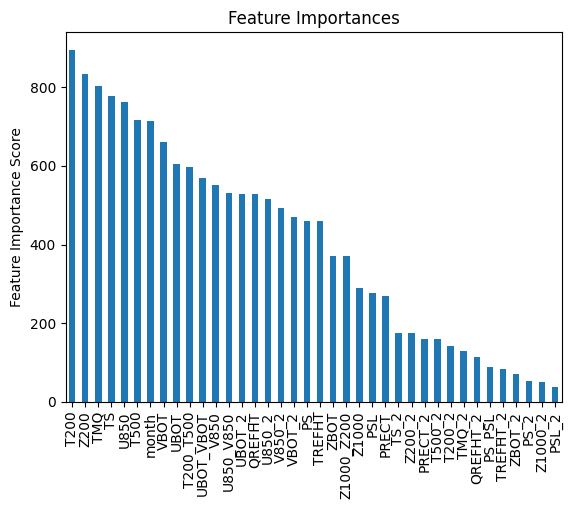

In [ ]:
#Train the initial model
predictors = [x for x in df_new.columns if x not in ['time', 'lat', 'lon','Label']]
xgb1 = xgb.sklearn.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 nthread=4,
 num_class=3,
 seed=42)
model = modelfit(xgb1, df_new, predictors, sample_weights)

In [ ]:
#Optimizing the max_depth and min_child_weight parameter
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.sklearn.XGBClassifier( learning_rate =0.1, n_estimators=221, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, seed=42),
 param_grid = param_test1, scoring='f1_micro',n_jobs=4,cv=5)
gsearch1.fit(df_new[predictors],df_new['Label'],sample_weight = sample_weights)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_ #error_score="raise"

({'mean_fit_time': array([23.00051088, 22.24822197, 21.23290405, 30.2297564 , 29.47815528,
         29.21495509, 46.09347401, 42.5897347 , 39.18527474, 66.70164008,
         56.33097358, 45.10263195]),
  'std_fit_time': array([1.23767567, 1.63399801, 2.68033957, 0.78672895, 0.82468471,
         0.72007395, 1.11375329, 1.52671702, 1.50688768, 3.12562307,
         1.88180428, 6.89658345]),
  'mean_score_time': array([0.24258113, 0.22515411, 0.17746444, 0.25225072, 0.31321435,
         0.41837029, 0.52740016, 0.55040364, 0.77506914, 0.74622078,
         0.79604959, 0.55408587]),
  'std_score_time': array([0.08775341, 0.06388749, 0.03097382, 0.02992844, 0.08405983,
         0.18867433, 0.05886293, 0.20097284, 0.17650961, 0.16619741,
         0.2834506 , 0.36806985]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?

In [ ]:
#Since the difference before was 2, we search around the current optimal value found for max_depth and min_child_weight
param_test2 = {
 'max_depth':[8,9,10],
 'min_child_weight':[1,2,3]
}
gsearch2 = GridSearchCV(estimator = xgb.sklearn.XGBClassifier(learning_rate=0.1, n_estimators=221, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, seed=42),
 param_grid = param_test2, scoring='f1_micro',n_jobs=4, cv=5)
gsearch2.fit(df_new[predictors],df_new['Label'], sample_weight = sample_weights)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([57.16179295, 51.62011809, 47.7876605 , 68.32641654, 60.54192796,
         56.47891126, 85.97674809, 74.83283672, 63.56432009]),
  'std_fit_time': array([ 2.01695971,  2.22742985,  0.66163635,  2.36989419,  1.34386557,
          1.97959295,  3.20090537,  3.49380721, 16.946857  ]),
  'mean_score_time': array([0.91826963, 0.48603597, 0.48660884, 0.69409947, 0.60910687,
         0.67992969, 1.09269023, 1.13656063, 0.62434239]),
  'std_score_time': array([0.2707575 , 0.0693978 , 0.08659725, 0.14571537, 0.12535623,
         0.19151557, 0.33338861, 0.20717296, 0.23918015]),
  'param_max_depth': masked_array(data=[8, 8, 8, 9, 9, 9, 10, 10, 10],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[1, 2, 3, 1, 2, 3, 1, 2, 3],
               mask=[False, False, False, False, False, False, False, False,
                 

In [ ]:
#Optimising gamma while fixing the optimal  max_depth and min_child_weight
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = xgb.sklearn.XGBClassifier( learning_rate =0.1, n_estimators=221, max_depth=10,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1,seed=27),
 param_grid = param_test3, scoring='f1_micro',n_jobs=4,cv=5)
gsearch3.fit(df_new[predictors],df_new['Label'], sample_weight = sample_weights)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [09:59:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


({'mean_fit_time': array([92.92940245, 75.57544575, 57.2265337 , 44.57923083, 39.26960592]),
  'std_fit_time': array([2.87500337, 6.09884507, 3.91534098, 2.72519281, 9.21248668]),
  'mean_score_time': array([0.89359946, 0.87240663, 0.67434149, 0.56935158, 0.34581046]),
  'std_score_time': array([0.11645409, 0.20985285, 0.21916461, 0.11527144, 0.0663378 ]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.8019437 , 0.80261394, 0.8036193 , 0.80462466, 0.80417784]),
  'split1_test_score': array([0.49776586, 0.48726542, 0.48235031, 0.45643432, 0.45799821]),
  'split2_test_score': array([0.46972744, 0.46012064, 0.44124218, 0.43867292, 0.44459339]),
  'split3_test_score': array([0.1152815 , 0.10198838, 0.09919571, 0.09495085, 0.094615

In [ ]:
#Retraining our model using the optimal params found yet, you will observe improvement over the score from before
xgb2 = xgb.sklearn.XGBClassifier(
 learning_rate =0.1,
 n_estimators=221,
 max_depth=10,
 min_child_weight=1,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 nthread=4,
 num_class=3,
 seed=42)
model = modelfit(xgb2, df_new, predictors, sample_weights)

In [ ]:
#Optimising subsample and colsample_bytree by fixing the before optimised parameters
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = xgb.sklearn.XGBClassifier( learning_rate =0.1, n_estimators=51, max_depth=10,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, seed=42),
 param_grid = param_test4, scoring='f1_micro',n_jobs=4,cv=5)
gsearch4.fit(df_new[predictors],df_new['Label'], sample_weight = sample_weights)
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([19.50152221, 20.17349453, 18.77597141, 18.34739842, 20.69298043,
         19.27514648, 19.1104351 , 22.58135095, 24.66326213, 25.10368867,
         25.68617697, 25.30704427, 25.26602407, 22.58550282, 21.96617608,
         22.91159768]),
  'std_fit_time': array([1.14927406, 1.37549167, 0.90422079, 0.62565378, 1.22743329,
         0.64051517, 1.10456242, 1.65945482, 1.20126222, 0.86097601,
         1.62814729, 1.95558235, 2.69994891, 0.84416895, 2.34367892,
         2.38029032]),
  'mean_score_time': array([0.16594782, 0.26678123, 0.16998129, 0.15957179, 0.24745011,
         0.1593864 , 0.23856139, 0.25090027, 0.2826231 , 0.25571594,
         0.31824832, 0.17365317, 0.11002421, 0.19861965, 0.17522068,
         0.17213345]),
  'std_score_time': array([0.07171235, 0.10441089, 0.03402455, 0.05069807, 0.06689983,
         0.05266018, 0.05151078, 0.08665298, 0.12558697, 0.0656798 ,
         0.0776427 , 0.04264712, 0.02233538, 0.10867149, 0.02697287,
         0.099355

In [ ]:
#Neighbourhood searches for subsample and colsample_bytree
param_test5 = {
 'subsample':[0.55,0.6,0.65],
 'colsample_bytree':[0.55,0.6,0.65]
}
gsearch5 = GridSearchCV(estimator = xgb.sklearn.XGBClassifier( learning_rate =0.1, n_estimators=51, max_depth=10,
 min_child_weight=1, gamma=0, subsample=0.6, colsample_bytree=0.6,
 objective= 'multi:softmax', nthread=4, seed=42),
 param_grid = param_test5, scoring='f1_micro',n_jobs=4,cv=5)
gsearch5.fit(df_new[predictors],df_new['Label'], sample_weight = sample_weights)
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([19.55749044, 21.68476791, 20.67722783, 21.14040093, 20.0832747 ,
         20.12921433, 19.98128877, 18.80196505, 17.53577371]),
  'std_fit_time': array([0.26284341, 0.57120431, 1.29136259, 0.5609045 , 1.12653467,
         1.00901051, 1.65450592, 0.83700382, 4.55403354]),
  'mean_score_time': array([0.22542706, 0.27011619, 0.23730211, 0.33121238, 0.26475992,
         0.29114728, 0.22854176, 0.20550942, 0.1820817 ]),
  'std_score_time': array([0.08926757, 0.04625519, 0.06648353, 0.05779713, 0.08880125,
         0.12494137, 0.09906221, 0.08923195, 0.09440489]),
  'param_colsample_bytree': masked_array(data=[0.55, 0.55, 0.55, 0.6, 0.6, 0.6, 0.65, 0.65, 0.65],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.55, 0.6, 0.65, 0.55, 0.6, 0.65, 0.55, 0.6, 0.65],
               mask=[False, False, False, False, False, Fa

In [ ]:
#Optimising reg_alpha and reg_lambda
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator =xgb.sklearn.XGBClassifier( learning_rate =0.1, n_estimators=51, max_depth=10,
 min_child_weight=1, gamma=0.0, subsample=0.6, colsample_bytree=0.55,
 objective= 'multi:softmax', nthread=4,seed=42),
 param_grid = param_test6, scoring='f1_micro',n_jobs=4, cv=5)
gsearch6.fit(df_new[predictors],df_new['Label'], sample_weight = sample_weights)
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

({'mean_fit_time': array([23.49164248, 19.85623689, 20.09101782, 20.5533061 , 21.06168685,
         21.93046327, 22.7301827 , 21.6510438 , 22.44197507, 17.7703053 ,
         20.80318375, 19.54171066, 21.53154969, 23.20761971, 20.28904357,
         20.89547057, 20.75369878, 20.6993576 , 17.00499673, 15.55265756,
          8.30339036,  6.83521452,  8.03450441,  8.33740726,  7.13325992]),
  'std_fit_time': array([0.63682457, 1.65275623, 0.9207368 , 0.31350365, 0.93215001,
         1.63331639, 2.19608048, 1.16633017, 1.84267548, 1.13760394,
         1.20192849, 1.86782804, 1.28088148, 1.71070299, 1.47509125,
         1.82307047, 1.0354162 , 1.75802236, 0.60258878, 0.67178988,
         1.01216348, 1.01550181, 0.95043318, 1.31037035, 1.41085293]),
  'mean_score_time': array([0.20112185, 0.27465525, 0.31014657, 0.22666097, 0.27981625,
         0.24252872, 0.25251908, 0.43490815, 0.25902014, 0.23977218,
         0.27155914, 0.22506709, 0.3623992 , 0.29468565, 0.30566583,
         0.20741739, 0

In [ ]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
 'reg_lambda':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator =xgb.sklearn.XGBClassifier( learning_rate =0.1, n_estimators=51, max_depth=10,
 min_child_weight=1, gamma=0.0, subsample=0.6, colsample_bytree=0.55,
 objective= 'multi:softmax', nthread=4,seed=42),
 param_grid = param_test7, scoring='f1_micro',n_jobs=4, cv=5)
gsearch7.fit(df_new[predictors],df_new['Label'], sample_weight = sample_weights)
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

({'mean_fit_time': array([22.65276184, 21.12703547, 18.66725144, 19.9342185 , 18.62964368,
         18.78609886, 19.34132748, 19.65116191, 17.81334596, 18.00120301,
         19.38833799, 18.79755716, 18.45653539, 18.87191863, 17.85860682,
         18.83306384, 18.00920854, 18.50500221, 17.88125901, 18.63017192,
         17.93710222, 17.9922399 , 17.22475519, 18.6883142 , 16.29737616]),
  'std_fit_time': array([0.66848778, 1.7519211 , 0.4168395 , 1.03016005, 0.64986903,
         0.90028527, 0.8515608 , 1.25786566, 1.0475647 , 1.2495418 ,
         1.39347464, 1.61661542, 1.07080611, 1.40965459, 1.04595584,
         1.17215812, 0.63521249, 1.24466439, 0.50851015, 1.13983664,
         1.1272384 , 0.57132067, 0.47235441, 0.99740135, 1.98851576]),
  'mean_score_time': array([0.24081984, 0.17369127, 0.1603107 , 0.22787099, 0.15541334,
         0.16993437, 0.18726149, 0.22438188, 0.20208702, 0.27766061,
         0.19292226, 0.22058849, 0.27150121, 0.15442438, 0.16083703,
         0.24628   , 0

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/ml_competition1_data/test.csv')
df_test.head()

data_test = df_test[['TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT',
       'PS', 'PSL', 'T200', 'T500', 'PRECT', 'TS', 'TREFHT', 'Z1000', 'Z200',
       'ZBOT']]
data_test_squared = data_test**2
data_test_squared.columns = [i+'_2' for i in list(data_test.columns)]

df_test_new = pd.concat([df_test, data_test_squared], axis=1)

df_test_new['month'] = df_test_new['time'].apply(lambda x: int(str(x)[4:6]))
df_test_new['U850_V850'] = df_test_new['U850']*df_test_new['V850']
df_test_new['UBOT_VBOT'] = df_test_new['UBOT']*df_test_new['VBOT']
df_test_new['PS_PSL'] = df_test_new['PS']*df_test_new['PSL']
df_test_new['T200_T500'] = df_test_new['T200']*df_test_new['T500']
df_test_new['Z1000_Z200'] = df_test_new['Z1000']*df_test_new['Z200']
df_test_new['U850_UBOT'] = df_test_new['U850']*df_test_new['UBOT']
df_test_new['V850_VBOT'] = df_test_new['V850']*df_test_new['VBOT']
df_test_new.head()

,SNo,lat,lon,TMQ,U850,V850,UBOT,VBOT,QREFHT,PS,...,Z200_2,ZBOT_2,month,U850_V850,UBOT_VBOT,PS_PSL,T200_T500,Z1000_Z200,U850_UBOT,V850_VBOT
0,1,-30.391134,354.375,25.907482,6.662070,-17.510447,-7.432653,-3.936030,0.010624,101532.5391,...,1.427712e+08,4064.352384,10,-116.655817,29.255146,1.030886e+10,54558.433699,1.551111e+06,-49.516856,68.921641
1,2,-30.391134,354.375,25.907482,6.662070,-17.510447,-7.432653,-3.936030,0.010624,101532.5391,...,1.427712e+08,4064.352384,10,-116.655817,29.255146,1.030886e+10,54558.433699,1.551111e+06,-49.516856,68.921641
2,3,-31.095176,354.375,27.019733,4.951319,-17.341263,-7.286631,-3.150316,0.010890,101513.0234,...,1.423504e+08,4064.565912,10,-85.862120,22.955189,1.030489e+10,54487.543220,1.529620e+06,-36.078433,54.630454
3,4,-31.095176,354.375,27.019733,4.951319,-17.341263,-7.286631,-3.150316,0.010890,101513.0234,...,1.423504e+08,4064.565912,10,-85.862120,22.955189,1.030489e+10,54487.543220,1.529620e+06,-36.078433,54.630454
4,5,-30.860495,354.375,26.516499,5.362008,-17.227922,-7.257047,-2.907396,0.010821,101505.1484,...,1.424711e+08,4065.472621,10,-92.376260,21.099109,1.030330e+10,54469.343551,1.522478e+06,-38.912343,50.088394


5814       train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0           0.760131       0.020605       0.756769      0.016388
1           0.774817       0.023634       0.771409      0.020880
2           0.799051       0.006401       0.795791      0.002836
3           0.802299       0.005538       0.798600      0.003103
4           0.806614       0.006202       0.802817      0.003358
...              ...            ...            ...           ...
5809        0.890421       0.001015       0.884479      0.001939
5810        0.890421       0.001015       0.884477      0.001939
5811        0.890421       0.001015       0.884477      0.001939
5812        0.890421       0.001015       0.884477      0.001939
5813        0.890430       0.001000       0.884483      0.001939

[5814 rows x 4 columns]

Model Report
Accuracy : 0.8566800714924039
(44760,) (44760,) (array([0, 1, 2], dtype=int32), array([38937,   973,  4850]))
test:  (array([0, 1, 2], dtype=int32), array([9016,  232, 1072]))


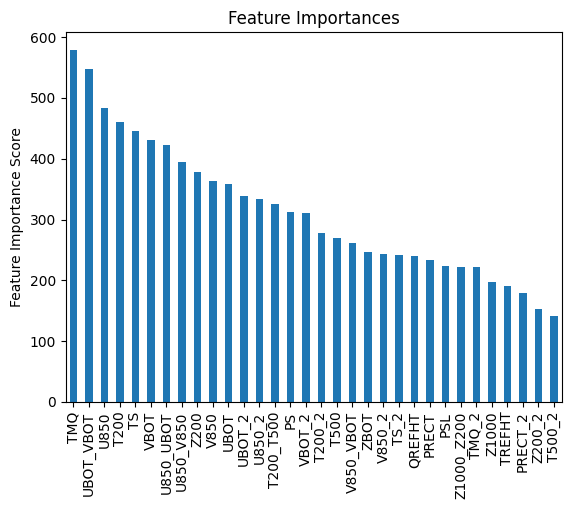

In [ ]:
#Final Model training
predictors = [x for x in df_new.columns if x not in ['time', 'lat', 'lon','Label',]]
xgb3 = xgb.sklearn.XGBClassifier(
 learning_rate = 0.1,
 n_estimators=10000,
 max_depth=10,
 min_child_weight=1,
 gamma=0.0,
 subsample=0.6,
 colsample_bytree=0.55,
 reg_alpha=100,
 reg_lambda=100
 objective= 'multi:softmax',
 nthread=4,
 num_class=3,
 seed=42)
y_pred = modelfit(xgb3, df_new, predictors, sample_weights, df_test_new) # reg_alpha=75,

In [ ]:
df_test['Label'] = y_pred
df_submit_1 = df_test[['SNo', 'Label']]
df_submit_1.to_csv('/content/drive/MyDrive/ml_competition1_data/submission25_xgboost_0.05_8_2_0_0.6_0.55_200.csv', index=False)